<a href="https://colab.research.google.com/github/TeRyZh/Big-Data-Analytics-for-Network-Level-Travel-Time-Prediction/blob/main/Notebooks/Stacked_BiLSTM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install cuda
!pip install pytorch_forecasting

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cpp-12 cuda-12-2 cuda-cccl-12-2 cuda-command-line-tools-12-2
  cuda-compiler-12-2 cuda-cudart-12-2 cuda-cudart-dev-12-2 cuda-cuobjdump-12-2
  cuda-cupti-12-2 cuda-cupti-dev-12-2 cuda-cuxxfilt-12-2 cuda-demo-suite-12-2
  cuda-documentation-12-2 cuda-driver-dev-12-2 cuda-drivers cuda-drivers-535
  cuda-gdb-12-2 cuda-libraries-12-2 cuda-libraries-dev-12-2 cuda-nsight-12-2
  cuda-nsight-compute-12-2 cuda-nsight-systems-12-2 cuda-nvcc-12-2
  cuda-nvdisasm-12-2 cuda-nvml-dev-12-2 cuda-nvprof-12-2 cuda-nvprune-12-2
  cuda-nvrtc-12-2 cuda-nvrtc-dev-12-2 cuda-nvtx-12-2 cuda-nvvp-12-2
  cuda-opencl-12-2 cuda-opencl-dev-12-2 cuda-profiler-api-12-2
  cuda-runtime-12-2 cuda-sanitizer-12-2 cuda-toolkit-12-2
  cuda-toolkit-12-2-config-common cuda-toolkit-12-config-common
  cuda-tools-12-2 cuda-visual-tools-12-2 dctrl-tools default-jre
  default-jre-he

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import numpy as np

plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


<ipython-input-3-e3eaf553b53b>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 31 05:48:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-01-01 00:00:00']

In [ ]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          if corridor_tt_2021['5 Minutes'].duplicated().any() :
            print(corridor["Corridor"], " ", corridor["Fwy-Dir"])
            continue
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

02: I-580   I580-W
31: Hwy 101   US101-S
31: Hwy 101   US101-S


In [ ]:
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg
0,2021-01-27 00:00:00,10.95,11.57,NaN,NaN,5.32,3.82,3.78,6.65,6.78,...,5.73,5.85,15.90,15.77,15.85,15.97,11.68,11.65,NaN,NaN
1,2021-01-27 00:05:00,11.00,11.62,NaN,NaN,5.33,3.87,3.93,6.68,6.92,...,5.78,5.85,15.97,15.83,16.07,16.05,12.12,11.63,NaN,NaN
2,2021-01-27 00:10:00,11.00,11.63,NaN,NaN,5.42,4.00,4.03,6.70,7.08,...,5.80,5.83,16.00,15.88,16.25,16.17,12.05,11.68,NaN,NaN
3,2021-01-27 00:15:00,11.00,11.63,NaN,NaN,5.45,4.07,4.13,6.68,7.07,...,5.85,5.85,16.02,15.98,16.25,16.18,12.13,11.68,NaN,NaN
4,2021-01-27 00:20:00,10.97,11.68,NaN,NaN,5.40,4.10,4.23,6.73,6.93,...,5.82,6.20,16.12,15.93,16.23,16.17,12.07,11.67,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77743,2021-10-31 23:35:00,10.93,11.63,NaN,NaN,NaN,4.00,3.83,6.57,6.78,...,5.75,5.92,15.73,15.82,15.95,15.32,11.67,11.23,NaN,NaN
77744,2021-10-31 23:40:00,10.92,11.63,NaN,NaN,NaN,4.03,3.77,6.57,6.75,...,5.73,5.92,15.73,15.90,15.90,15.40,11.82,11.28,NaN,NaN
77745,2021-10-31 23:45:00,10.88,11.62,NaN,NaN,NaN,4.05,3.78,6.52,6.70,...,5.73,5.90,15.75,15.85,15.82,15.55,11.75,11.40,NaN,NaN
77746,2021-10-31 23:50:00,10.88,11.60,NaN,NaN,NaN,3.95,3.85,6.55,6.75,...,5.73,6.03,15.73,15.75,15.63,15.75,11.67,11.55,NaN,NaN


In [ ]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x
0,2021-01-27 00:00:00,10.95,11.57,10.92,4.07,4.03,1.25,1.27,13.15,13.13,...,13.97,13.83,18.43,18.73,25.93,25.72,5.73,5.85,15.90,15.77
1,2021-01-27 00:05:00,11.00,11.62,10.93,4.15,4.05,1.27,1.27,13.20,13.12,...,13.97,13.85,18.47,18.75,26.15,25.68,5.78,5.85,15.97,15.83
2,2021-01-27 00:10:00,11.00,11.63,10.93,4.20,4.20,1.28,1.27,13.35,13.12,...,13.97,13.87,18.47,18.75,26.18,25.73,5.80,5.83,16.00,15.88
3,2021-01-27 00:15:00,11.00,11.63,10.93,4.17,4.13,1.28,1.27,13.35,13.10,...,13.95,13.87,18.47,18.73,26.02,25.87,5.85,5.85,16.02,15.98
4,2021-01-27 00:20:00,10.97,11.68,11.02,4.15,4.13,1.27,1.27,13.33,13.12,...,13.95,13.85,18.45,18.72,26.03,25.80,5.82,6.20,16.12,15.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77743,2021-10-31 23:35:00,10.93,11.63,10.82,4.12,4.08,1.27,1.30,13.12,15.40,...,14.00,13.97,18.42,18.78,25.77,25.60,5.75,5.92,15.73,15.82
77744,2021-10-31 23:40:00,10.92,11.63,10.83,4.13,4.08,1.25,1.32,13.08,15.50,...,14.00,13.97,18.40,18.82,25.77,25.82,5.73,5.92,15.73,15.90
77745,2021-10-31 23:45:00,10.88,11.62,10.93,4.13,4.08,1.28,1.30,13.05,15.25,...,14.00,13.95,18.40,18.82,25.82,25.73,5.73,5.90,15.75,15.85
77746,2021-10-31 23:50:00,10.88,11.60,10.83,4.13,4.07,1.27,1.30,13.03,14.87,...,13.98,13.97,18.40,18.83,25.80,25.60,5.73,6.03,15.73,15.75


In [ ]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [ ]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,...,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39
0,2021-01-27 00:00:00,10.95,11.57,10.92,4.07,4.03,1.25,1.27,13.15,13.13,...,13.97,13.83,18.43,18.73,25.93,25.72,5.73,5.85,15.90,15.77
1,2021-01-27 00:05:00,11.00,11.62,10.93,4.15,4.05,1.27,1.27,13.20,13.12,...,13.97,13.85,18.47,18.75,26.15,25.68,5.78,5.85,15.97,15.83
2,2021-01-27 00:10:00,11.00,11.63,10.93,4.20,4.20,1.28,1.27,13.35,13.12,...,13.97,13.87,18.47,18.75,26.18,25.73,5.80,5.83,16.00,15.88
3,2021-01-27 00:15:00,11.00,11.63,10.93,4.17,4.13,1.28,1.27,13.35,13.10,...,13.95,13.87,18.47,18.73,26.02,25.87,5.85,5.85,16.02,15.98
4,2021-01-27 00:20:00,10.97,11.68,11.02,4.15,4.13,1.27,1.27,13.33,13.12,...,13.95,13.85,18.45,18.72,26.03,25.80,5.82,6.20,16.12,15.93
5,2021-01-27 00:25:00,11.00,11.70,11.15,4.13,4.28,1.27,1.27,13.35,13.17,...,13.97,13.85,18.45,18.72,26.15,25.97,5.80,5.98,16.13,16.02
6,2021-01-27 00:30:00,11.02,11.68,11.17,4.13,4.17,1.27,1.27,13.40,13.15,...,13.97,13.85,18.45,18.72,26.03,25.97,5.78,5.92,16.02,15.98
7,2021-01-27 00:35:00,10.98,11.68,11.37,4.30,4.13,1.27,1.27,13.35,13.12,...,13.97,13.85,18.45,18.72,26.00,25.85,5.80,5.87,15.97,15.95
8,2021-01-27 00:40:00,10.93,11.68,11.18,4.23,4.20,1.27,1.27,13.28,13.10,...,14.00,13.85,18.45,18.73,25.95,25.77,5.78,6.32,15.97,15.90
9,2021-01-27 00:45:00,10.95,11.70,11.02,4.17,4.15,1.27,1.27,13.35,13.13,...,13.98,13.85,18.45,18.73,25.83,25.78,5.80,6.75,15.93,15.92


In [ ]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])

    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
# print(total_data)

In [ ]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]

# scaler = MinMaxScaler(feature_range=(0,1))
# total = scaler.fit_transform(total_data)
# # train = scaler.transform(train_data)
# total = scaler.transform(total_data)

# sc = MinMaxScaler()
# total_data = sc.fit_transform(total_data)

total = total_data.to_numpy()

## 15 minutes horizon
trn_x_15min, trn_y_15min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 2)  # 15 minute.
vld_x_15min, vld_y_15min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 2)  # 15 minute.
tst_x_15min, tst_y_15min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 2)  # 15 minute.

trn_x_15min = trn_x_15min.reshape(-1,time_steps, num_corridor)
vld_x_15min = vld_x_15min.reshape(-1,time_steps, num_corridor)
tst_x_15min = tst_x_15min.reshape(-1,time_steps, num_corridor)


## 30 minutes horizon
trn_x_30min, trn_y_30min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 5)  # 30 minute.
vld_x_30min, vld_y_30min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 5)  # 30 minute.
tst_x_30min, tst_y_30min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 5)  # 30 minute.

trn_x_30min = trn_x_30min.reshape(-1,time_steps, num_corridor)
vld_x_30min = vld_x_30min.reshape(-1,time_steps, num_corridor)
tst_x_30min = tst_x_30min.reshape(-1,time_steps, num_corridor)


## 45 minutes horizon
trn_x_45min, trn_y_45min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 8)  # 45 minute..
vld_x_45min, vld_y_45min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 8)  # 45 minute.
tst_x_45min, tst_y_45min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 8)  # 45 minute.

trn_x_45min = trn_x_45min.reshape(-1,time_steps, num_corridor)
vld_x_45min = vld_x_45min.reshape(-1,time_steps, num_corridor)
tst_x_45min = tst_x_45min.reshape(-1,time_steps, num_corridor)


In [ ]:
# conver the data to tensors and pass to the Dataloader
# to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, num_corridor, seq_length, hidden_size, num_layers, drop_prob = 0.5, nfc = 512):
        super(BiLSTM, self).__init__()

        self.num_corridor = num_corridor
        self.num_layers = num_layers
        self.hidden_size = hidden_size * num_layers * 2 # bidirectional *2
        self.seq_length = seq_length

        self.bilstm = nn.LSTM(input_size=num_corridor, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional = True)

        self.fc = nn.Linear(self.hidden_size, num_corridor)

        self.output_layer =  nn.Sequential(
            nn.Linear(self.hidden_size, nfc),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(nfc, nfc),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(nfc, num_corridor),
        )


    def forward(self, x):

        # Propagate input through bidirectionalLSTM
        ula, (h_out, _) = self.bilstm(x)
        # h_out.shape (num_layers, batch, hidden_size)

        h_out = torch.transpose(h_out, 1, 0)

        h_out = h_out.reshape(-1, self.hidden_size)

        out = self.output_layer(h_out)

        return out

## 15 Minute Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BiLSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_15min)))
trainY = Variable(torch.Tensor(np.array(trn_y_15min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_15min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_15min)))

testX = Variable(torch.Tensor(np.array(tst_x_15min)))
testY = Variable(torch.Tensor(np.array(tst_y_15min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch
        # print("targets shape", targets.shape)
        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)
        model = model.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        # print(y_pred.shape)
        # print(targets.shape)
        loss = criterion(y_pred, targets)
        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/Stacked_BiLSTM_15min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)

        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = sc.inverse_transform(y_pred)
            # targets = sc.inverse_transform(targets)

            mae_test += mean_absolute_error(y_pred, targets)

            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:

      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 2.02632534 val_loss: 0.89817151 
epoch: 20 | trn_loss: 1.26396232 val_loss: 0.85433766 
epoch: 30 | trn_loss: 1.14288622 val_loss: 0.54236645 
epoch: 40 | trn_loss: 1.10094068 val_loss: 0.52135833 
epoch: 50 | trn_loss: 1.04791898 val_loss: 0.51277445 
epoch: 60 | trn_loss: 1.02277069 val_loss: 0.47230642 
epoch: 70 | trn_loss: 0.96516154 val_loss: 0.43452051 
epoch: 80 | trn_loss: 0.94844873 val_loss: 0.45427136 
epoch: 90 | trn_loss: 0.94413935 val_loss: 0.48156127 
epoch: 100 | trn_loss: 0.91628519 val_loss: 0.54187914 
epoch: 110 | trn_loss: 0.87331418 val_loss: 0.42441472 
epoch: 120 | trn_loss: 0.88006990 val_loss: 0.42689755 
epoch: 130 | trn_loss: 0.86728714 val_loss: 0.46950013 
epoch: 140 | trn_loss: 0.82247535 val_loss: 0.43780056 
epoch: 150 | trn_loss: 0.80790305 val_loss: 0.46729128 
epoch: 160 | trn_loss: 0.82486288 val_loss: 0.42288948 
epoch: 170 | trn_loss: 0.78931229 val_loss: 0.42660727 
epoch: 180 | trn_loss: 0.76057454 val_loss: 0.41908231 
e

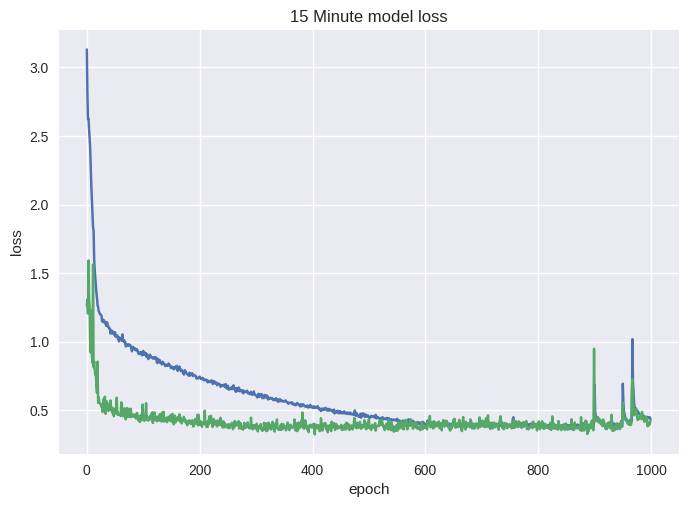

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('15 Minute model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 30 Minute Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BiLSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_30min)))
trainY = Variable(torch.Tensor(np.array(trn_y_30min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_30min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_30min)))

testX = Variable(torch.Tensor(np.array(tst_x_30min)))
testY = Variable(torch.Tensor(np.array(tst_y_30min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/Stacked_BiLSTM_30min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)

        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = sc.inverse_transform(y_pred)
            # targets = sc.inverse_transform(targets)

            mae_test += mean_absolute_error(y_pred, targets)

            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:

      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 2.56347180 val_loss: 1.24225317 
epoch: 20 | trn_loss: 1.70561771 val_loss: 0.89910381 
epoch: 30 | trn_loss: 1.33870580 val_loss: 0.67929797 
epoch: 40 | trn_loss: 1.22857228 val_loss: 0.62808371 
epoch: 50 | trn_loss: 1.19519680 val_loss: 0.60115951 
epoch: 60 | trn_loss: 1.12053310 val_loss: 0.58901618 
epoch: 70 | trn_loss: 1.10055830 val_loss: 0.57995545 
epoch: 80 | trn_loss: 1.08846497 val_loss: 0.62223910 
epoch: 90 | trn_loss: 1.04700233 val_loss: 0.56360243 
epoch: 100 | trn_loss: 1.03676851 val_loss: 0.54678992 
epoch: 110 | trn_loss: 0.98903668 val_loss: 0.52412380 
epoch: 120 | trn_loss: 0.96604562 val_loss: 0.54671743 
epoch: 130 | trn_loss: 0.98547001 val_loss: 0.54285983 
epoch: 140 | trn_loss: 0.91057986 val_loss: 0.55105370 
epoch: 150 | trn_loss: 0.92293010 val_loss: 0.59746904 
epoch: 160 | trn_loss: 0.89635539 val_loss: 0.55330491 
epoch: 170 | trn_loss: 0.88334721 val_loss: 0.52740546 
epoch: 180 | trn_loss: 0.86810634 val_loss: 0.50995372 
e

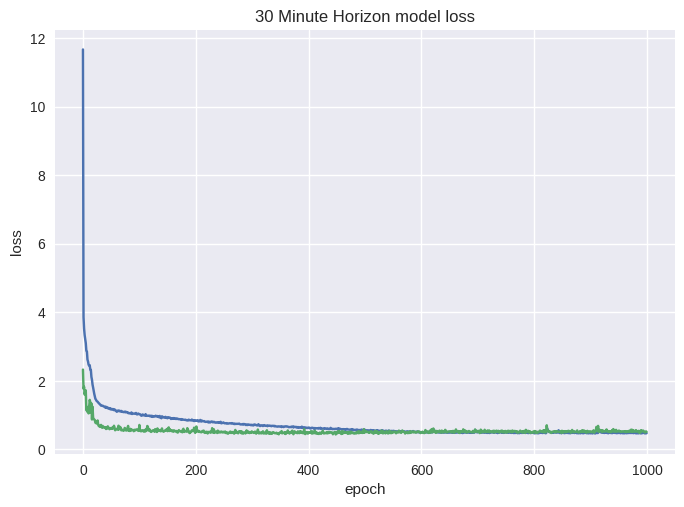

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('30 Minute Horizon model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 45 Minute Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BiLSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_45min)))
trainY = Variable(torch.Tensor(np.array(trn_y_45min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_45min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_45min)))

testX = Variable(torch.Tensor(np.array(tst_x_45min)))
testY = Variable(torch.Tensor(np.array(tst_y_45min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/Stacked_BiLSTM_45min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)

        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = sc.inverse_transform(y_pred)
            # targets = sc.inverse_transform(targets)

            mae_test += mean_absolute_error(y_pred, targets)

            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)


        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:

      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 2.61849058 val_loss: 1.23578751 
epoch: 20 | trn_loss: 1.83579968 val_loss: 1.07972247 
epoch: 30 | trn_loss: 1.43187359 val_loss: 0.81585967 
epoch: 40 | trn_loss: 1.32866322 val_loss: 0.68406506 
epoch: 50 | trn_loss: 1.26085440 val_loss: 0.67170413 
epoch: 60 | trn_loss: 1.22646095 val_loss: 0.63329346 
epoch: 70 | trn_loss: 1.20656372 val_loss: 0.68513592 
epoch: 80 | trn_loss: 1.17881787 val_loss: 0.68669567 
epoch: 90 | trn_loss: 1.15183486 val_loss: 0.65963189 
epoch: 100 | trn_loss: 1.11625812 val_loss: 0.65127981 
epoch: 110 | trn_loss: 1.11930382 val_loss: 0.64474023 
epoch: 120 | trn_loss: 1.10541297 val_loss: 0.63617047 
epoch: 130 | trn_loss: 1.06085883 val_loss: 0.60530685 
epoch: 140 | trn_loss: 1.03823461 val_loss: 0.62872960 
epoch: 150 | trn_loss: 1.03178943 val_loss: 0.60735185 
epoch: 160 | trn_loss: 1.01642943 val_loss: 0.66521047 
epoch: 170 | trn_loss: 0.99699790 val_loss: 0.59564561 
epoch: 180 | trn_loss: 0.97224889 val_loss: 0.59760805 
e

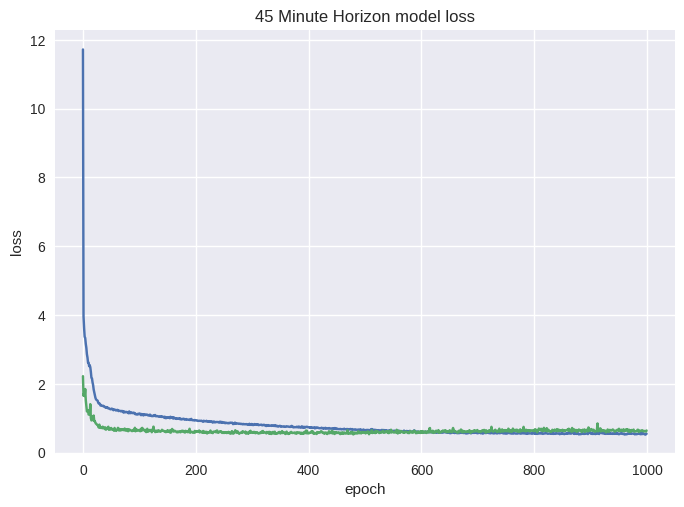

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('45 Minute Horizon model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()